<a href="https://colab.research.google.com/github/SamoaChen/Frequentist-ML/blob/main/Single_and_Multi_Class_Logistic_Regression_with_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#--------------IMPORT  PACKAGES

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

#-------------IMPORT DATA
SAheart = pd.read_csv("SAheart.csv", sep=',', header=0)
#CLEAN UP DATA
SAheart = SAheart.drop(SAheart.columns[0], axis=1)
SAheart['famhist'] = pd.get_dummies(SAheart['famhist'],drop_first=True)
SAheart

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...
457,214,0.40,5.98,31.72,0,64,28.45,0.00,58,0
458,182,4.20,4.41,32.10,0,52,28.61,18.72,52,1
459,108,3.00,1.59,15.23,0,40,20.09,26.64,55,0
460,118,5.40,11.61,30.79,0,64,27.35,23.97,40,0


In [ ]:
#---------------SEPERATE TRAINING VALIDATION AND TESTING DATA
SAheart_train , SAheart_remain = train_test_split(SAheart, test_size=0.2, random_state=100, shuffle=True)
SAheart_valid , SAheart_test = train_test_split(SAheart_remain, test_size=0.5, random_state=50, shuffle=True)

#---------------SEPERATE FEATURES AND LABELS
SAheart_train_x=SAheart_train[SAheart_train.columns[0:9]]
SAheart_train_y=SAheart_train["chd"]
SAheart_valid_x=SAheart_valid[SAheart_valid.columns[0:9]]
SAheart_valid_y=SAheart_valid["chd"]
SAheart_test_x=SAheart_test[SAheart_test.columns[0:9]]
SAheart_test_y=SAheart_test["chd"]

#---------------STANDARDIZE FEATURES
SAheart_train_x=(SAheart_train_x-SAheart_train_x.mean())/SAheart_train_x.std(ddof=1)
SAheart_valid_x=(SAheart_valid_x-SAheart_valid_x.mean())/SAheart_valid_x.std(ddof=1)
SAheart_test_x=(SAheart_test_x-SAheart_test_x.mean())/SAheart_test_x.std(ddof=1)

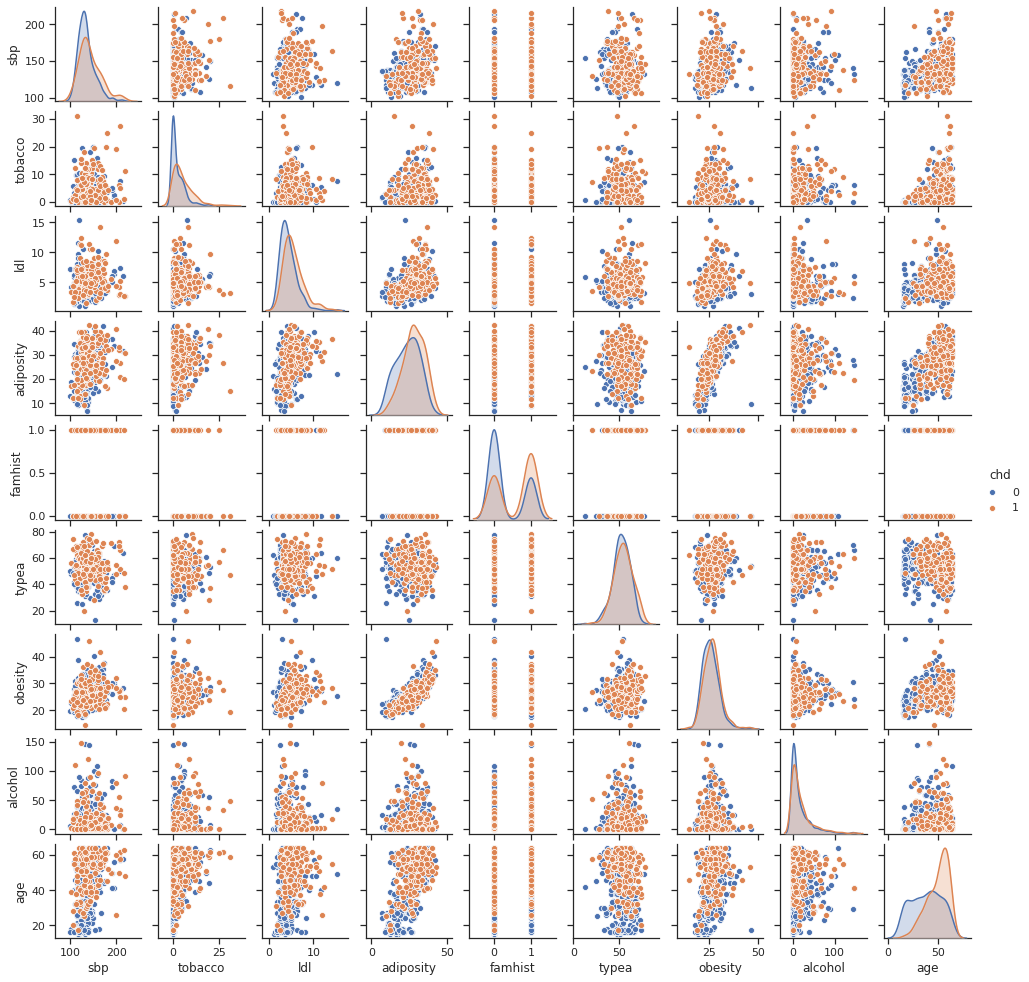

In [ ]:
#---------------PAIRPLOT
sns.set(style="ticks", color_codes=True)
sns.pairplot(SAheart, hue='chd', height=1.5)

#*Logistic Regression Without Regularization*

In [ ]:
#--------------LOGISTIC REGRESSION WITHOUT REGULARIZATION
#CONVERT DATA TO NUMPY FORMAT
train_x=SAheart_train_x.to_numpy()
train_y=SAheart_train_y.to_numpy()
valid_x=SAheart_valid_x.to_numpy()
valid_y=SAheart_valid_y.to_numpy()
test_x=SAheart_test_x.to_numpy()
test_y=SAheart_test_y.to_numpy()
#--------------DATA FOR L2 L1 REGRESSION
train_x_reg=train_x
train_y_reg=train_y
valid_x_reg=valid_x
valid_y_reg=valid_y
test_x_reg=test_x
test_y_reg=test_y
#--------------CONCATENATE COLUMN OF 1s
train_x=np.concatenate((np.ones((train_x.shape[0],1)),train_x), axis=1)
valid_x=np.concatenate((np.ones((valid_x.shape[0],1)),valid_x), axis=1)
test_x=np.concatenate((np.ones((test_x.shape[0],1)),test_x), axis=1)
#--------------INCREASE TRAINING SIZE BY DUPLICATING
#train_x=np.concatenate((train_x,train_x),axis=1)
#train_y=np.array([np.append(train_y,train_y)])

#DEFINE FUNCTION FOR h
def h(theta,x):
  h=1/(1+np.exp(-theta.transpose().dot(x)))
  return h.item()

#DEFINE FUNCTION FOR STOCHASTIC GRADIENT ASCENT
def sga(theta_old,alpha,y,x):
  theta_new=theta_old+alpha*((y-h(theta_old,x)*x)).reshape(theta_old.shape[0],1)
  return theta_new

#DEFINE FUNCTION FOR STOCHASTIC GRADIENT ASCENT WITH L2 REGULARIZATION
def sga_l2(theta_old,alpha,lamb,y,x):
  theta_new=theta_old+alpha*((y-h(theta_old,x)*x)).reshape(theta_old.shape[0],1)-2*lamb*theta_old
  return theta_new

#DEFINE FUNCTION FOR STOCHASTIC GRADIENT ASCENT WITH L1 REGULARIZATION
def sga_l1(theta_old,alpha,lamb,y,x):
  theta_new=theta_old+alpha*((y-h(theta_old,x)*x)).reshape(theta_old.shape[0],1)-(lamb*0.0027/train_x.shape[0])*np.sign(theta_old)
  return theta_new

#DEFINE FUNCTION FOR STOCHASTIC GRADIENT ASCENT WITH L1 REGULARIZATION THAT CAN OUTPUT 0 WEIGHTS
def sga_l1_0(theta_old,alpha,lamb,y,x):
  theta_new=theta_old+alpha*((y-h(theta_old,x)*x)).reshape(theta_old.shape[0],1)
  #LOOP THROUGH EACH WEIGHT TERM
  for term in range(theta_new.size):
    if theta_new[term] > 0:
      theta_new[term] = np.maximum(0, theta_new[term]-(lamb*0.0027/train_x.shape[0]))
    elif theta_new[term] < 0:
      theta_new[term] = np.minimum(0, theta_new[term]+(lamb*0.0027/train_x.shape[0]))
  return theta_new

#DEFINE FUNCTION FOR OPTIMIZE THETA FOR L2 REGULARIZATION
def theta_find_l2(train_x,train_y,lamb):
  #INITIATE THETA
  theta=np.zeros((train_x.shape[1],1))
  iteration=np.arange(1,train_y.shape[0]+1)
  for step in range(train_y.shape[0]):
    theta=sga_l2(theta,0.0027,lamb,train_y[step],train_x[step,:])
    
  return theta

#DEFINE FUNCTION FOR OPTIMIZE THETA FOR L1 REGULARIZATION
def theta_find_l1(train_x,train_y,lamb):
  #INITIATE THETA
  theta=np.zeros((train_x.shape[1],1))
  iteration=np.arange(1,train_y.shape[0]+1)
  for step in range(train_y.shape[0]):
    theta=sga_l1(theta,0.0027,lamb,train_y[step],train_x[step,:])
    
  return theta

#DEFINE FUNCTION FOR OPTIMIZE THETA FOR L1 REGULARIZATION THAT CAN RESULT IN 0 WEIGHTS
def theta_find_l1_0(train_x,train_y,lamb):
  #INITIATE THETA
  theta=np.zeros((train_x.shape[1],1))
  iteration=np.arange(1,train_y.shape[0]+1)
  for step in range(train_y.shape[0]):
    theta=sga_l1_0(theta,0.0027,lamb,train_y[step],train_x[step,:])
    
  return theta

#DEFINE FUNCTION FOR OPTIMIZE THETA WITHOUT REGULARIZATION
def theta_find(train_x,train_y):
  #INITIATE THETA
  theta=np.zeros((train_x.shape[1],1))
  iteration=np.arange(1,train_y.shape[0]+1)
  for step in range(train_y.shape[0]):
    theta=sga(theta,0.0027,train_y[step],train_x[step,:])

  return theta

#DEFINE FUNCTION FOR LOG LIKELIHOOD
def lld_cal(theta):
  lld=0
  for i in range(train_y.shape[0]):
    lld=lld+(train_y[i]*np.log(h(theta,train_x[i,:]))+(1-train_y[i])*np.log(1-h(theta,train_x[i,:])))
  return lld

#DEFINE FUNCTION FOR PREDICTION
def prediction(theta,x_set):
  y_pred_array=[]
  for step in range(x_set.shape[0]):
    y_pred=h(theta,x_set[step,:])
    if y_pred > 0.5:
      y_pred_array=np.append(y_pred_array,1)
    else:
      y_pred_array=np.append(y_pred_array,0)

  y_pred_array=np.transpose(np.array([y_pred_array]))
  return y_pred_array
#DEFINE % CORRECT FUNCTION
def perc_cor(y_pred,y_actual):
  acc = sum(y_pred == y_actual)/y_actual.shape[0]
  return acc[0]


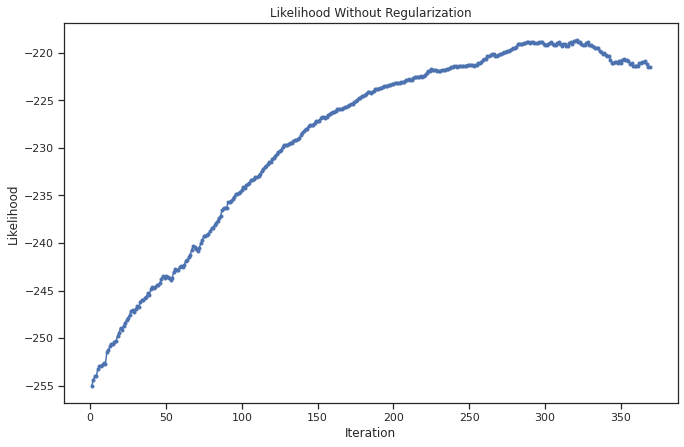

Optimal feature parameters without regularization: 
 [[-0.14837836]
 [ 0.26409021]
 [ 0.26494789]
 [ 0.25949048]
 [ 0.23272222]
 [ 0.27503928]
 [ 0.29549935]
 [ 0.25407282]
 [ 0.27932231]
 [ 0.24207399]]


In [ ]:
#-------------LOOP FOR FINDING THE THETA THAT MAXIMIZE LIKELIHOOD FUNCTION
#INITIATE THETA
theta=np.zeros((train_x.shape[1],1))
#lld ARRAY FOR PLOTTING
lld_non_reg=[]
iteration=np.arange(1,train_y.shape[0]+1)

for step in range(train_y.shape[0]):
  lld=0
  theta=sga(theta,0.0027,train_y[step],train_x[step,:])
  lld_non_reg=np.append(lld_non_reg,lld_cal(theta))

#-------------PLOT CHANGE OF LIKELIHOOD
plt.figure(figsize=(11,7))

plt.plot(iteration,lld_non_reg,marker='.')
plt.title('Likelihood Without Regularization')
plt.ylabel('Likelihood')
plt.xlabel('Iteration')
#plt.legend(loc='best')
plt.show()

print("Optimal feature parameters without regularization: \n",theta)

In [ ]:
p_c=perc_cor(prediction(theta,test_x),test_y)
print("The percentage correctness for just logistic regression: ","{:.0%}".format(p_c))

The percentage correctness for just logistic regression:  66%


#*Base Case Analysis*

In [ ]:
# Percent of people that is in class '1'
sum(train_y == 1)/train_y.size

0.33062330623306235

Because there is less people who belongs to class '1', so assume all possible outcome to be '0'

In [ ]:
#CONSTRUCT y_pred TO BE ALL 0
predict_base=np.zeros(test_y.size)
acc = sum(predict_base == test_y)/test_y.shape[0]
print("The percentage correctness for base case: ","{:.0%}".format(acc))

The percentage correctness for base case:  60%


#*Logistic Regression With L2 Regularization*

In [ ]:
#----------------FIND THE OPTIMAL LAMBDA VALUE
#INITIATE THETA
theta=np.zeros((train_x.shape[1],1))

#PROVIDE LAMBDA FOR SWEEPING
lam_vect = np.linspace(0,0.8,num=200)

#THETA ARRAY FOR PLOTTING
theta_array=np.zeros((train_x.shape[1],lam_vect.size))

#INITIALIZE PLACE FOR STORING PERCENTAGE CORRECTNESS
vals = np.zeros(lam_vect.shape)

#FIND PERCENTAGE CORRECTNESS FOR EACH LAMBDA
for index,val in enumerate(lam_vect):
    theta = theta_find_l2(train_x,train_y,val)
    y_pred = prediction(theta,valid_x)
    vals[index] = perc_cor(y_pred,valid_y)
    theta_array[:,index] = theta.reshape(1,theta.shape[0])

#LOCATE THE LAMBDA THAT OPTIMIZE ACCURACY
maxpos = np.where(vals == vals.max())
best_lam = lam_vect[maxpos]

In [ ]:
maxpos

(array([135, 136, 137, 138, 142, 143]),)

In [ ]:
p_c=perc_cor(prediction(theta_array[:,138].reshape(theta.shape[0],1),test_x),test_y)
print("The percentage correctness for just logistic regression: ","{:.0%}".format(p_c))



The percentage correctness for just logistic regression:  70%


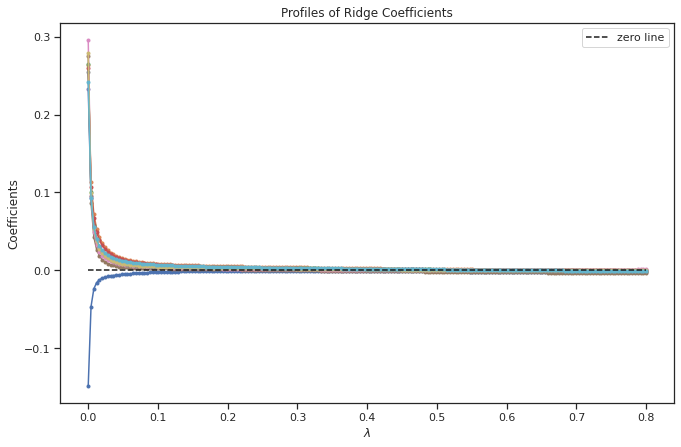

In [ ]:
#-------------PLOT CHANGING WEIGHT WITH RESPECT TO LAMBDA VALUES
plt.figure(figsize=(11,7))

for beta_num in range(theta_array.shape[0]):
  plt.plot(lam_vect,theta_array[beta_num,:],marker='.')

plt.plot((0,0.8 ), (0, 0), 'k--',label="zero line")
plt.title('Profiles of Ridge Coefficients')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
plt.legend(loc='best')
plt.show()

#*Forward Step Wise Feature Selection*

In [ ]:
#-----------------THE CASE TO FIND ONLY ONE FEATURE
#INITIATE THETA
theta=np.zeros((train_x.shape[1],1))
#INITIALIZE PLACE FOR STORING PERCENTAGE CORRECTNESS
vals = np.zeros(train_x_reg.shape[1])  

for feature_num in range(1,train_x.shape[1]):
  #FIND % CORRECTNESS FOR EACH FEATURE
  t_x = train_x[:, [0, feature_num]]
  theta = theta_find(t_x,train_y)
  y_pred = prediction(theta,valid_x[:,[0, feature_num]])
  vals[feature_num-1] = perc_cor(y_pred,valid_y)

#LOCATE THE LAMBDA THAT OPTIMIZE ACCURACY
maxpos = np.where(vals == vals.max())
#TRANFER COORDINATE BACK TO FEATURE POSITION
maxpos = [n + 1 for n in maxpos]

print("Feature(s) with best % correctness: \n",maxpos)


Feature(s) with best % correctness: 
 [array([2])]


The second feature result in the maximum % correctness, so is chosen as the first feature

In [ ]:
#------------------THE CASE TO FIND TWO FEATURES
#INITIALIZE PLACE FOR STORING PERCENTAGE CORRECTNESS
vals = np.zeros(train_x_reg.shape[1])  

for feature_num in [1,3,4,5,6,7,8,9]:
  #FIND % CORRECTNESS FOR EACH FEATURE
  t_x = train_x[:, [0,2, feature_num]]
  theta = theta_find(t_x,train_y)
  y_pred = prediction(theta,valid_x[:,[0,2, feature_num]])
  vals[feature_num-1] = perc_cor(y_pred,valid_y)
  
#LOCATE THE LAMBDA THAT OPTIMIZE ACCURACY
maxpos = np.where(vals == vals.max())
#TRANFER COORDINATE BACK TO FEATURE POSITION
maxpos = [n + 1 for n in maxpos]

print("Feature(s) with best % correctness: \n",maxpos)

Feature(s) with best % correctness: 
 [array([7, 8])]


The third and eighth feature result in highest % correctness, so for this step chose the thrid

In [ ]:
#------------------THE CASE TO FIND THREE FEATURES
#INITIALIZE PLACE FOR STORING PERCENTAGE CORRECTNESS
vals = np.zeros(train_x_reg.shape[1])  

for feature_num in [1,4,5,6,7,8,9]:
  #FIND % CORRECTNESS FOR EACH FEATURE
  t_x = train_x[:, [0,2,3, feature_num]]
  theta = theta_find(t_x,train_y)
  y_pred = prediction(theta,valid_x[:,[0,2,3, feature_num]])
  vals[feature_num-1] = perc_cor(y_pred,valid_y)

#LOCATE THE LAMBDA THAT OPTIMIZE ACCURACY
maxpos = np.where(vals == vals.max())
#TRANFER COORDINATE BACK TO FEATURE POSITION
maxpos = [n + 1 for n in maxpos]

print("Feature(s) with best % correctness: \n",maxpos)

Feature(s) with best % correctness: 
 [array([8])]


The seventh and eighth features result in max % correctness, so chose eighth for this step

In [ ]:
#------------------THE CASE TO FIND FOUR FEATURES
#INITIALIZE PLACE FOR STORING PERCENTAGE CORRECTNESS
vals = np.zeros(train_x_reg.shape[1])  

for feature_num in [1,4,5,6,7,9]:
  #FIND % CORRECTNESS FOR EACH FEATURE
  t_x = train_x[:, [0,2,3,8, feature_num]]
  theta = theta_find(t_x,train_y)
  y_pred = prediction(theta,valid_x[:,[0,2,3,8, feature_num]])
  vals[feature_num-1] = perc_cor(y_pred,valid_y)

#LOCATE THE LAMBDA THAT OPTIMIZE ACCURACY
maxpos = np.where(vals == vals.max())
#TRANFER COORDINATE BACK TO FEATURE POSITION
maxpos = [n + 1 for n in maxpos]

print("Feature(s) with best % correctness: \n",maxpos)

Feature(s) with best % correctness: 
 [array([6])]


The fifth result in max % correctness, chose fifth as the forth feature

In [ ]:
#------------------THE CASE TO FIND FIVE FEATURES
#INITIALIZE PLACE FOR STORING PERCENTAGE CORRECTNESS
vals = np.zeros(train_x_reg.shape[1])  

for feature_num in [1,4,6,7,9]:
  #FIND % CORRECTNESS FOR EACH FEATURE
  t_x = train_x[:, [0,2,3,8,5, feature_num]]
  theta = theta_find(t_x,train_y)
  y_pred = prediction(theta,valid_x[:,[0,2,3,8,5, feature_num]])
  vals[feature_num-1] = perc_cor(y_pred,valid_y)

#LOCATE THE LAMBDA THAT OPTIMIZE ACCURACY
maxpos = np.where(vals == vals.max())
#TRANFER COORDINATE BACK TO FEATURE POSITION
maxpos = [n + 1 for n in maxpos]

print("Feature(s) with best % correctness: \n",maxpos)

Feature(s) with best % correctness: 
 [array([4, 7])]


The forth and seventh features result in max % correctness, so chose seventh for this step

In [ ]:
#------------------THE CASE TO FIND SIX FEATURES
#INITIALIZE PLACE FOR STORING PERCENTAGE CORRECTNESS
vals = np.zeros(train_x_reg.shape[1])  

for feature_num in [1,4,6,9]:
  #FIND % CORRECTNESS FOR EACH FEATURE
  t_x = train_x[:, [0,2,3,8,5,7, feature_num]]
  theta = theta_find(t_x,train_y)
  y_pred = prediction(theta,valid_x[:,[0,2,3,8,5,7, feature_num]])
  vals[feature_num-1] = perc_cor(y_pred,valid_y)

#LOCATE THE LAMBDA THAT OPTIMIZE ACCURACY
maxpos = np.where(vals == vals.max())
#TRANFER COORDINATE BACK TO FEATURE POSITION
maxpos = [n + 1 for n in maxpos]

print("Feature(s) with best % correctness: \n",maxpos)

Feature(s) with best % correctness: 
 [array([6])]


The sixth result in highest % correctness, so chosen for this step

In [ ]:
#------------------THE CASE TO FIND SEVEN FEATURES
#INITIALIZE PLACE FOR STORING PERCENTAGE CORRECTNESS
vals = np.zeros(train_x_reg.shape[1])  

for feature_num in [1,4,9]:
  #FIND % CORRECTNESS FOR EACH FEATURE
  t_x = train_x[:, [0,2,3,8,5,7,6, feature_num]]
  theta = theta_find(t_x,train_y)
  y_pred = prediction(theta,valid_x[:,[0,2,3,8,5,7,6, feature_num]])
  vals[feature_num-1] = perc_cor(y_pred,valid_y)

#LOCATE THE LAMBDA THAT OPTIMIZE ACCURACY
maxpos = np.where(vals == vals.max())
#TRANFER COORDINATE BACK TO FEATURE POSITION
maxpos = [n + 1 for n in maxpos]

print("Feature(s) with best % correctness: \n",maxpos)

Feature(s) with best % correctness: 
 [array([1])]



SUMMARY: The second feature results in the best prediction model, and the % correctness decreased when extra features are added into the prediction model.
The seven most important features from most important to least important are tobacco, ldl, age, famhist, alcohol, obesity, sbp. This list matches with the features selected in the text book example

#*Logistic Regression With L1 Regularization*

In [ ]:
#----------------FIND THE OPTIMAL LAMBDA VALUE
#INITIATE THETA
theta=np.zeros((train_x.shape[1],1))

#PROVIDE LAMBDA FOR SWEEPING
lam_vect = np.linspace(0,180,num=1000)

#THETA ARRAY FOR PLOTTING
theta_array=np.zeros((train_x.shape[1],lam_vect.size))

#INITIALIZE PLACE FOR STORING PERCENTAGE CORRECTNESS
vals = np.zeros(lam_vect.shape)

#FIND PERCENTAGE CORRECTNESS FOR EACH LAMBDA
for index,val in enumerate(lam_vect):
    theta = theta_find_l1(train_x,train_y,val)
    y_pred = prediction(theta,valid_x)
    vals[index] = perc_cor(y_pred,valid_y)
    theta_array[:,index] = theta.reshape(1,theta.shape[0])

#LOCATE THE LAMBDA THAT OPTIMIZE ACCURACY
maxpos = np.where(vals == vals.max())
best_lam = lam_vect[maxpos]

In [ ]:
maxpos

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 999]),)

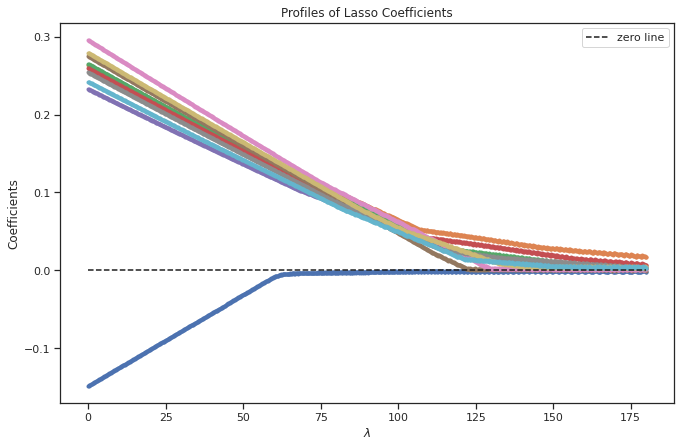

In [ ]:
#-------------PLOT CHANGING WEIGHT WITH RESPECT TO LAMBDA VALUES
plt.figure(figsize=(11,7))

for beta_num in range(theta_array.shape[0]):
  plt.plot(lam_vect,theta_array[beta_num,:],marker='.')

plt.plot((0, 180), (0, 0), 'k--',label="zero line")
plt.title('Profiles of Lasso Coefficients')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
plt.legend(loc='best')
plt.show()

In [ ]:
p_c=perc_cor(prediction(theta_array[:,0].reshape(theta.shape[0],1),test_x),test_y)
print("The percentage correctness for just logistic regression: ","{:.0%}".format(p_c))

The percentage correctness for just logistic regression:  66%


The percent correctness is less than the one calculated for L2 regresssion, this may caused by the nature of the naive method that wieght can not go to 0

#*Repeat the Analysis on extra data set*

In [ ]:
#--------------IMPORT  PACKAGES

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt')
features = ["variance","skewness","curtosis","entropy"]
label = "real"
df.columns = features + [label]

In [ ]:
df

,variance,skewness,curtosis,entropy,real
0,4.54590,8.16740,-2.4586,-1.46210,0
1,3.86600,-2.63830,1.9242,0.10645,0
2,3.45660,9.52280,-4.0112,-3.59440,0
3,0.32924,-4.45520,4.5718,-0.98880,0
4,4.36840,9.67180,-3.9606,-3.16250,0
...,...,...,...,...,...
1366,0.40614,1.34920,-1.4501,-0.55949,1
1367,-1.38870,-4.87730,6.4774,0.34179,1
1368,-3.75030,-13.45860,17.5932,-2.77710,1
1369,-3.56370,-8.38270,12.3930,-1.28230,1


In [ ]:
#---------------SEPERATE TRAINING VALIDATION AND TESTING DATA
Bank_train , Bank_remain = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)
Bank_valid , Bank_test = train_test_split(Bank_remain, test_size=0.5, random_state=1, shuffle=True)

#---------------SEPERATE FEATURES AND LABELS
X_train=Bank_train[Bank_train.columns[0:4]]
y_train=Bank_train["real"]
X_validation=Bank_valid[Bank_valid.columns[0:4]]
y_validation=Bank_valid["real"]
X_test=Bank_test[Bank_test.columns[0:4]]
y_test=Bank_test["real"]

#---------------STANDARDIZE FEATURES
Bank_train_x=(Bank_train_x-Bank_train_x.mean())/Bank_train_x.std(ddof=1)
Bank_valid_x=(Bank_valid_x-Bank_valid_x.mean())/Bank_valid_x.std(ddof=1)
Bank_test_x=(Bank_test_x-Bank_test_x.mean())/Bank_test_x.std(ddof=1)

In [ ]:
figsize=(18,7)

def log_likelihood_plot(log_likelihoods, title="Log Likelihood vs. Iteration Number", ax=None):
  if ax is None:
    plt.figure(figsize=figsize)
    plt.plot(range(1, len(log_likelihoods)+1),log_likelihoods,marker='.')
    plt.title(title)
    plt.ylabel('Likelihood')
    plt.xlabel('Iteration')
  else:
    ax.plot(range(1, len(log_likelihoods)+1),log_likelihoods,marker='.')
    ax.set_ylabel('Likelihood')
    ax.set_xlabel('Iteration')
    ax.title(title)


def penalty_sweep_plot(penalties, thetas, penalty_type, title="Profiles of Coefficients", ax=None):
  if ax is None:
    plt.figure(figsize=figsize)

    for theta in np.transpose(thetas):
      plt.plot(penalties,theta.flatten(),marker='.')

    plt.plot((0,0.5 ), (0, 0), 'k--',label="zero line")
    plt.title(title)
    plt.ylabel('Coefficients')
    plt.xlabel('$\lambda_{}$'.format(penalty_type))
    plt.legend(loc='best')

  else:

    for theta in np.transpose(thetas):
      ax.plot(penalties,theta.flatten(),marker='.')

    ax.plot((0,0.5 ), (0, 0), 'k--',label="zero line")
    ax.title(title)
    ax.set_ylabel('Coefficients')
    ax.set_xlabel('$\lambda_{}$'.format(penalty_type))
    ax.legend(loc='best')

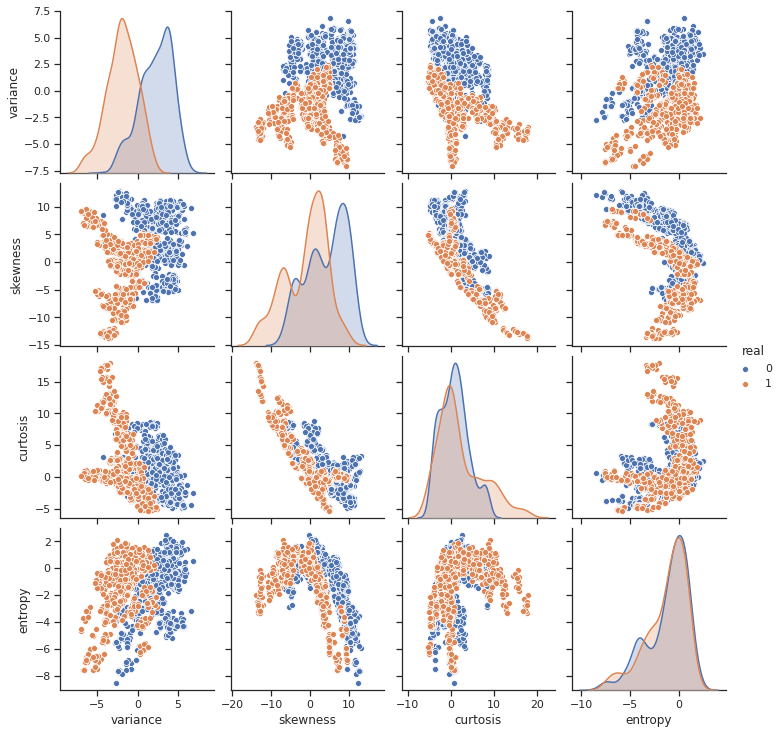

In [ ]:
#---------------PAIRPLOT
sns.set(style="ticks", color_codes=True)
sns.pairplot(df, hue='real')

In [ ]:
# logistic function
def sigmoid(z):
  # From Andrew Ng's CS229 notes, Section 5: Logistic Regression
  return 1/(1 + np.exp(-1*z))

def softmax(logits):
  # From Andrew Ng's CS229 notes, Section 9: Constructing GLMs
  return np.exp(logits)/np.sum(np.exp(logits))

def h(x, theta, g = sigmoid):
  # Handles both binomial and multionomial classification with specifiable activation
  # From Andrew Ng's CS229 notes, Section 5: Logistic Regression
  result = g(np.transpose(theta) @ x)
  if result.size == 1:
    return result.item()
  else:
    return result.flatten()

def dll_dtheta(theta, X, y, activation_func = sigmoid):
  # From Andrew Ng's CS229 notes, Section 5: Logistic Regression
  return (y - h(X, theta, activation_func))*X

# SGA update rule
def sga(theta, alpha, X, y, l1_penalty=0, l2_penalty=0, l1_penalty_type=None, activation_func = sigmoid):
  # Handles both binomial and multionomial classification with specifiable activation

  if not l1_penalty_type:
    # The 2 is somewhat arbitrary (comes from the differentiation of the square term)
    # Implementation of L2 penalty, unregularized in the case l2_penalty = 0
    return theta + alpha*dll_dtheta(theta, X, y, activation_func = activation_func) - 2*l2_penalty*theta
  elif l1_penalty_type == "naive":
    # Naive implementation from Tsuruoka et al., linked in the assignment text.
    return theta + alpha*dll_dtheta(theta, X, y, activation_func = activation_func) - (l1_penalty/len(X))*alpha*np.sign(theta)
  elif l1_penalty_type == "clipping":
    # Clipping method from Tsuruoka et al.
    theta_new = theta + alpha*dll_dtheta(theta, X, y, activation_func = activation_func)
    for i, theta_term in enumerate(theta_new):
      if theta_term > 0:
        theta_new[i] = np.max([0, theta_term - (l1_penalty/len(X))*alpha])
      elif theta_term < 0:
        theta_new[i] = np.min([0, theta_term + (l1_penalty/len(X))*alpha])
    return theta_new

def log_likelihood(theta, X, y, activation_func = sigmoid):
  # Handles both binomial and multionomial classification with specifiable activation
  ll = 0
  if len(y.shape) > 1:
    y_num_cols = y.shape[1]
  else:
    y_num_cols = 1

  if y_num_cols == 1:
    # Binomial case, from Andrew Ng's CS229 notes, Section 5: Logistic Regression 
    for i in range(len(y)):
      ll += y[i]*np.log(h(X[i, :], theta, activation_func)) + (1-y[i])*np.log(1-h(X[i, :], theta, activation_func))
  else:
    # From Andrew Ng's CS229 notes, Section 5: Logistic Regression
    for i in range(len(y)):
      ll += np.log(np.prod(np.power(h(X[i, :], theta, activation_func), y[i])))
  return ll

def logistic_regression(X, y, alpha, l1_penalty=0, l2_penalty=0, l1_penalty_type=None, output_log_likelihoods=False, append_ones = True, activation_func = sigmoid):

  # Enforce only L1 or L2 used at a time
  assert not (l1_penalty and l2_penalty), "L1 and L2 combined regularization not supported"
  assert not (l1_penalty_type and l2_penalty), "Cannot specify L2 penalty and L1 penalty type"
  if l1_penalty:
      assert l1_penalty_type, "Must specify penalty type for L1 regularization. Supported options: naive, clipping"
  
  if append_ones:
    X_mat = np.append(np.array([1] * len(X)).reshape(-1, 1), X.values.copy(), axis=1)
  else:
    X_mat = X.copy()

  y_mat = y.values.copy()
  X_num_cols = X_mat.shape[1]
  if len(y_mat.shape) > 1:
    y_num_cols = y_mat.shape[1]
  else:
    y_num_cols = 1

  # Theta initialized as columm vector in the binomial case with additional columns in multinomial,
  # so that the tranposition and multiplication in the h function works out as dot-product.
  theta = np.zeros((X_num_cols, y_num_cols))

  if output_log_likelihoods:
    log_likelihoods = []
    for j in range(len(y_mat)):
      theta = sga(theta, alpha, np.array([X_mat[j, :]]).transpose(), y_mat[j], l1_penalty, l2_penalty, l1_penalty_type, activation_func = activation_func)
      log_likelihoods.append(log_likelihood(theta, X_mat, y_mat, activation_func))
    return theta, log_likelihoods
  else:
    for j in range(len(y_mat)):
      theta = sga(theta, alpha, np.array([X_mat[j, :]]).transpose(), y_mat[j], l1_penalty, l2_penalty, l1_penalty_type, activation_func = activation_func)
    return theta

def predict(theta, X, activation_func = sigmoid, append_ones = True):
  if append_ones:
    X_mat = np.append(np.array([1] * len(X)).reshape(-1, 1), X.values.copy(), axis=1)
  else:
    X_mat = X.copy()

  logits = np.array([h(theta, x_row, activation_func) for x_row in X_mat])
  if len(logits.shape) > 1:
    predictions = np.zeros_like(logits)
    predictions[range(len(logits)), np.argmax(logits, axis=1)] = 1
  else:
    predictions =  np.array([round(h(theta, x_row)) for x_row in X_mat])
  return predictions

def score_accuracy(y_prediction, y_actual):
  assert len(y_prediction) == len(y_actual), "Length of prediction and actual arrays must be equal"
  if len(y_prediction.shape) > 1:
    return np.sum(np.all(y_prediction == y_actual, axis=1))/len(y_actual)
  else:
    return sum(y_prediction == y_actual)/len(y_actual)

def l1_parameter_search(l1s, X_train, y_train, X_validation, y_validation, alpha, l1_penalty_type):
  # Given an array of L1s and a penalty implementation, find the best one, and return all of the weights as well for plotting purposes
  thetas = []
  
  best_l1_penalty = l1s[0]
  best_theta = logistic_regression(X_train, y_train, alpha, l1_penalty=l1s[0], l1_penalty_type=l1_penalty_type)
  best_score = score_accuracy(predict(best_theta, X_validation), y_validation)
  thetas.append(best_theta.T)
  if len(l1s) > 1:
    for l1_penalty in l1s[1:]:
      theta = logistic_regression(X_train, y_train, alpha, l1_penalty=l1_penalty, l1_penalty_type=l1_penalty_type)
      thetas.append(theta.T)
      score = score_accuracy(predict(theta, X_validation), y_validation)
      if score > best_score:
        best_l1_penalty = l1_penalty
        best_theta = theta
        best_score = score
  return best_l1_penalty, best_theta, best_score, thetas

def l2_parameter_search(l2s, X_train, y_train, X_validation, y_validation, alpha):
  # Given an array of L2s, find the best one, and return all of the weights as well for plotting purposes
  thetas = []

  best_l2_penalty = l2s[0]
  best_theta = logistic_regression(X_train, y_train, alpha, l2_penalty=l2s[0])
  best_score = score_accuracy(predict(best_theta, X_validation), y_validation)
  thetas.append(best_theta.T)
  if len(l2s) > 1:
    for l2_penalty in l2s[1:]:
      theta = logistic_regression(X_train, y_train, alpha, l2_penalty=l2_penalty)
      thetas.append(theta.T)
      score = score_accuracy(predict(theta, X_validation), y_validation)
      if score > best_score:
        best_l2_penalty = l2_penalty
        best_theta = theta
        best_score = score
  return best_l2_penalty, best_theta, best_score, thetas

def forward_stepwise_selection(X_train, y_train, X_validation, y_validation, alpha, l1_penalty=0, l2_penalty=0, l1_penalty_type=None):
  # Strategy: Find which column yields best predictions, then find which additional column yields best predictions, and so on until all the columns have been included and can be ranked.

  X_train_mat = np.append(np.array([1] * len(X_train)).reshape(-1, 1), X_train.values.copy(), axis=1)
  X_validation_mat = np.append(np.array([1] * len(X_validation)).reshape(-1, 1), X_validation.values.copy(), axis=1)

  num_features = X_train_mat.shape[1] - 1

  # Maintain a list of remaining features to use, and a list of selected features by descending order of their predictive importance
  feature_ranking = []
  remaining_features = list(range(1, num_features+1))
  while len(remaining_features) > 1:
    X_cols_to_use = [0] + [feature for feature in feature_ranking] + [remaining_features[0]]
    X_train_subset = X_train_mat[:, X_cols_to_use]
    X_validation_subset = X_validation_mat[:, X_cols_to_use]
    best_feature = remaining_features[0]
    best_index = 0

    theta = logistic_regression(X_train_subset, y_train, alpha, l1_penalty=l1_penalty, l2_penalty=l2_penalty, l1_penalty_type=l1_penalty_type, output_log_likelihoods=False, append_ones = False)
    best_score = score_accuracy(predict(theta, X_validation_subset, append_ones=False), y_validation)

    print("Cols: {}, Score: {}".format([feature_num - 1 for feature_num in X_cols_to_use[1:]], best_score))
    
    for feature_num in remaining_features[1:]:
      X_cols_to_use = [0] + [feature for feature in feature_ranking] + [feature_num]
      X_train_subset = X_train_mat[:, X_cols_to_use ]
      X_validation_subset = X_validation_mat[:, X_cols_to_use]
      theta = logistic_regression(X_train_subset, y_train, alpha, l1_penalty=l1_penalty, l2_penalty=l2_penalty, l1_penalty_type=l1_penalty_type, output_log_likelihoods=False, append_ones = False)
      score = score_accuracy(predict(theta, X_validation_subset, append_ones=False), y_validation)
      print("Cols: {}, Score: {}".format([feature_num - 1 for feature_num in X_cols_to_use[1:]], score))
      if score > best_score:
        best_feature = feature_num
    feature_ranking.append(best_feature)
    print("Best performance for {} iteratively selected cols: {}".format(len(feature_ranking),[feature_num - 1 for feature_num in feature_ranking]))
    remaining_features.remove(best_feature)
  feature_ranking.append(remaining_features[0])
  feature_ranking = [feature_num - 1 for feature_num in feature_ranking]
  print("Final ranking, descending: {}".format(feature_ranking))
  return feature_ranking


  #DEFINE FUNCTION FOR PREDICTION
def prediction(theta,x_set):
  y_pred_array=[]
  for step in range(x_set.shape[0]):
    y_pred=h(theta,x_set[step,:])
    if y_pred > 0.5:
      y_pred_array=np.append(y_pred_array,1)
    else:
      y_pred_array=np.append(y_pred_array,0)

  y_pred_array=np.transpose(np.array([y_pred_array]))
  return y_pred_array
#DEFINE % CORRECT FUNCTION
def perc_cor(y_pred,y_actual):
  acc = sum(y_pred == y_actual)/y_actual.shape[0]
  return acc[0]


Unregularized logistic regression model with alpha=0.0027
Model weights: [ 0.16333803 -0.79385877 -0.36996239 -0.39483059 -0.18133534]
Model accuracy: 94.16058394160584%


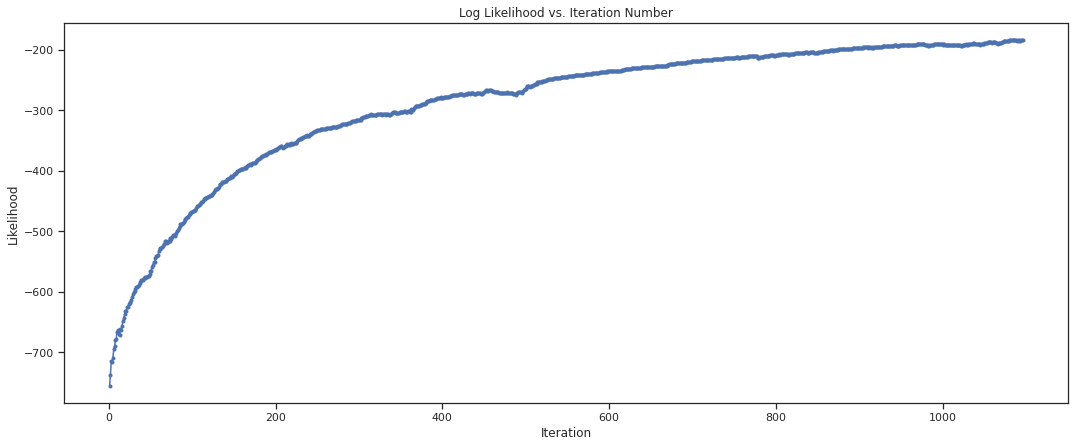

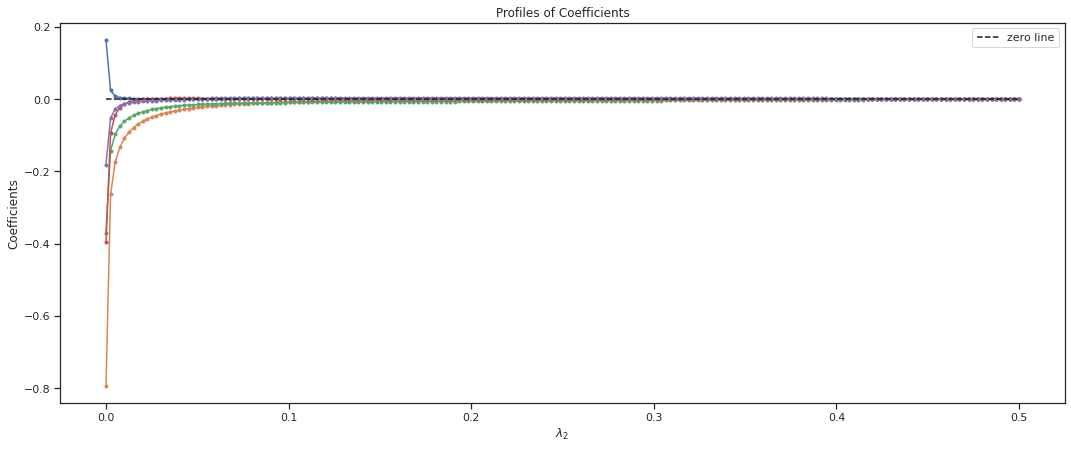

[[ 0.16333803]
 [-0.79385877]
 [-0.36996239]
 [-0.39483059]
 [-0.18133534]]


In [ ]:
alpha = 0.0027
theta, log_likelihoods = logistic_regression(X_train, y_train, alpha, output_log_likelihoods=True)

print("Unregularized logistic regression model with alpha={}".format(alpha))
print("Model weights: {}".format(theta.flatten()))
print("Model accuracy: {}%".format(100*score_accuracy(predict(theta, X_validation), y_validation.values)))
log_likelihood_plot(log_likelihoods)
plt.show()

l2_candidates = np.linspace(0, 0.5, num=200)
best_l2_penalty, best_theta, best_score, thetas = l2_parameter_search(l2_candidates, X_train, y_train, X_validation, y_validation, alpha)
penalty_sweep_plot(l2_candidates, thetas, "2")
plt.show()

print(best_theta)
#l1_candidates = np.linspace(0,150,num=1000)
#best_l1_penalty, best_theta, best_score, thetas = l1_parameter_search(l1_candidates, X_train, y_train, X_validation, y_validation, alpha, "naive")
#penalty_sweep_plot(l1_candidates, thetas, "1", "Coefficients for naive $L_1$ Implementation")
#plt.show()

#l1_candidates = np.linspace(0,150,num=1000)
#best_l1_penalty, best_theta, best_score, thetas = l1_parameter_search(l1_candidates, X_train, y_train, X_validation, y_validation, alpha, "clipping")
#penalty_sweep_plot(l1_candidates, thetas, "1", "Coefficients for clipping $L_1$ Implementation")
#plt.show()

#feature_ranking = forward_stepwise_selection(X_train, y_train, X_validation, y_validation, alpha, l1_penalty=0, l2_penalty=0, l1_penalty_type=None)
#print("Ranked column names, descending: {}".format(X_train.columns.values[feature_ranking]))

#*Multiclass Classification*

In [ ]:
#--------------IMPORT  PACKAGES

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

#-------------IMPORT DATA
Iris = pd.read_csv("iris.csv", sep=',', header=0)
Iris

,Sepal L,Sepal W,Petal L,Petal W,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


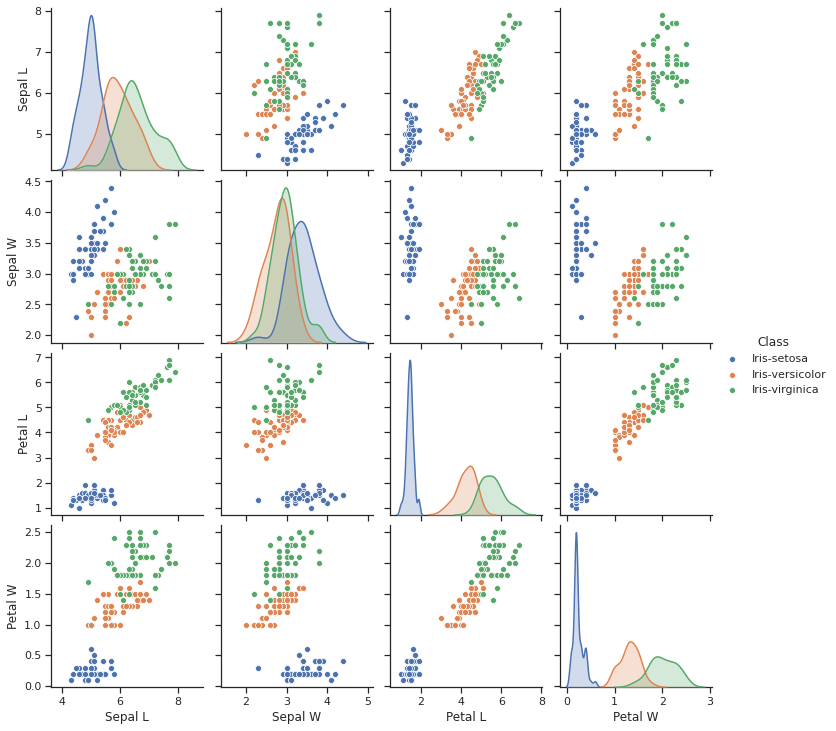

In [ ]:
#---------------PAIRPLOT
#FORMAT DATA FOR PAIRPLOT
Iris_pairplot=Iris

sns.set(style="ticks", color_codes=True)
sns.pairplot(Iris_pairplot, hue='Class')

In [ ]:
#---------------CREATE MULTICLASSES
Iris['Versicolor'] = np.where(Iris['Class']!= 'Iris-versicolor', 0, 1)
Iris['Virginica'] = np.where(Iris['Class']!= 'Iris-virginica', 0, 1)
Iris['Setosa'] = np.where(Iris['Class']!= 'Iris-setosa', 0, 1)
Iris = Iris.drop(Iris.columns[4], axis=1)
Iris

,Sepal L,Sepal W,Petal L,Petal W,Versicolor,Virginica,Setosa
0,5.1,3.5,1.4,0.2,0,0,1
1,4.9,3.0,1.4,0.2,0,0,1
2,4.7,3.2,1.3,0.2,0,0,1
3,4.6,3.1,1.5,0.2,0,0,1
4,5.0,3.6,1.4,0.2,0,0,1
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,1,0
146,6.3,2.5,5.0,1.9,0,1,0
147,6.5,3.0,5.2,2.0,0,1,0
148,6.2,3.4,5.4,2.3,0,1,0


In [ ]:
#---------------SEPERATE TRAINING VALIDATION AND TESTING DATA
Iris_train , Iris_remain = train_test_split(Iris, test_size=0.2, random_state=50, shuffle=True)
Iris_valid , Iris_test = train_test_split(Iris_remain, test_size=0.5, random_state=50, shuffle=True)

#---------------SEPERATE FEATURES AND LABELS
Iris_train_x = Iris_train[Iris_train.columns[0:4]]
Iris_train_y = Iris_train[Iris_train.columns[4:7]]
Iris_valid_x = Iris_valid[Iris_valid.columns[0:4]]
Iris_valid_y = Iris_valid[Iris_valid.columns[4:7]]
Iris_test_x = Iris_test[Iris_test.columns[0:4]]
Iris_test_y = Iris_test[Iris_test.columns[4:7]]

#---------------STANDARDIZE FEATURES
Iris_train_x=(Iris_train_x-Iris_train_x.mean())/Iris_train_x.std(ddof=1)
Iris_valid_x=(Iris_valid_x-Iris_valid_x.mean())/Iris_valid_x.std(ddof=1)
Iris_test_x=(Iris_test_x-Iris_test_x.mean())/Iris_test_x.std(ddof=1)


In [ ]:
#--------------LOGISTIC REGRESSION WITHOUT REGULARIZATION
#CONVERT DATA TO NUMPY FORMAT
train_x = Iris_train_x.to_numpy()
train_y = Iris_train_y.to_numpy()
valid_x = Iris_valid_x.to_numpy()
valid_y = Iris_valid_y.to_numpy()
test_x = Iris_test_x.to_numpy()
test_y = Iris_test_y.to_numpy()

#--------------CONCATENATE COLUMN OF 1s
train_x=np.concatenate((np.ones((train_x.shape[0],1)),train_x), axis=1)
valid_x=np.concatenate((np.ones((valid_x.shape[0],1)),valid_x), axis=1)
test_x=np.concatenate((np.ones((test_x.shape[0],1)),test_x), axis=1)

#--------------DEFINE FUNCTIONS FOR MULTICLASS CLASSIFICATION
#DEFINE FUNCTION FOR SOFTMAX
def softmax(theta_m,x):
  #DEFINE ACTIVATION ARRAY
  a = np.zeros(theta_m.shape[0])
  #DEFINE SOFTMAX ARRAY
  sofm = np.zeros(theta_m.shape[0])
  #CALCULATE ACTIVATIONS
  for step in range(theta_m.shape[0]):
    a[step] = np.exp(theta_m[step,:].dot(x))
  #CALCULATE SOFTMAXS
  for step in range(theta_m.shape[0]):
    sofm[step] = a[step]/a.sum()
  return sofm


#DEFINE FUNCTION FOR MULTICLASS STOCHASTIC GRADIENT DESCENT
def sgd(train_x,train_y,alpha,theta_m_old):
  #INITIATE THE LIKELIHOOD GRADIENT FOR POPULATING
  lh_gradient = np.zeros((train_y.shape[1],train_x.shape[1]))
  #LOOP THROUGH ALL SAMPLES
  for sample_num in range(train_x.shape[0]):
    #CALCULATE SOFMAX FOR EACH SAMPLE
    sofm = softmax(theta_m_old,train_x[sample_num,:])
    #LOOP THROUGH ALL WEIGHT FUNCTION
    for theta_num in range(theta_m_old.shape[0]):
      lh_gradient[theta_num,:] = lh_gradient[theta_num,:]+(sofm[theta_num]-train_y[sample_num,theta_num])*train_x[sample_num,:]
  theta_m = theta_m_old-alpha*lh_gradient
  return theta_m

#DEFINE FUNCTION FOR MULTICLASS STOCHASTIC GRADIENT DESCENT WITH ONE SAMPLE AT EACH STEP
def sgd_1sample(x,y,alpha,theta_m_old):
  #INITIATE THE LIKELIHOOD GRADIENT FOR POPULATING
  lh_gradient = np.zeros((y.size,x.size))
  #CALCULATE SOFMAX FOR EACH SAMPLE
  sofm = softmax(theta_m_old,x)
  #LOOP THROUGH ALL WEIGHT FUNCTION
  for theta_num in range(theta_m_old.shape[0]):
    lh_gradient[theta_num,:] = lh_gradient[theta_num,:]+(sofm[theta_num]-y[theta_num])*x
  theta_m = theta_m_old-alpha*lh_gradient
  return theta_m

#DEFINE FUNCTION TO CALCULATE LOG LIKELIHOOD FOR MULTICLASS CLASSIFICATION
def lld_cal_multiclass(theta_m):
  lld=0
  for sample_num in range(train_x.shape[0]):
    sofm = softmax(theta_m,train_x[sample_num,:])
    for theta_num in range(theta_m.shape[0]):
      lld=lld+train_y[sample_num,theta_num]*np.log(sofm[theta_num])
  return -lld

#DEFINE PERCENT CORRECTNESS FOR MULTICLASS CLASSIFICATION
def percent_corr_multiclass(theta_m,test_x,test_y):
  y_pred = np.zeros((test_x.shape[0],test_y.shape[1]))
  for sample_num in range(test_x.shape[0]):
    sofm = softmax(theta_m, test_x[sample_num,:])
    maxpos = np.argmax(sofm)
    if maxpos == 0:
      y_pred[sample_num,0] = 1
    elif maxpos == 1:
      y_pred[sample_num,1] = 1
    elif maxpos == 2:
      y_pred[sample_num,2] = 1
  
  acc = sum(sum((y_pred+test_y) == 2))/test_y.shape[0]
  return acc  



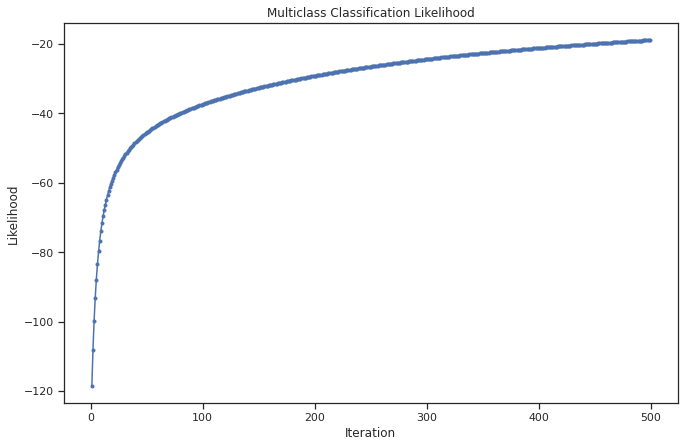

In [ ]:
#----------------CALCULATE OPTIMAL WEIGHTS WITH METHOD THAT USES ALL SMAPLES FOR ONE STEP
#INITIATE THE WEIGHT MATRIX
theta_m = np.zeros((train_y.shape[1],train_x.shape[1]))

#TIMES IT LOOPED THROUGH THE TRAINING SET
iteration = np.arange(1,500)
#EMPTY ARRAY FOR LIKELIHOOD
lld_multiclass = np.zeros(iteration.shape)
for iterate in iteration:
  theta_m = sgd(train_x,train_y,0.001,theta_m)

  lld_multiclass[iterate-1]=-lld_cal_multiclass(theta_m)

#---------------PLOT THE LIKELIHOOD VS ITERATIONS
plt.figure(figsize=(11,7))

plt.plot(iteration,lld_multiclass,marker='.')
plt.title('Multiclass Classification Likelihood')
plt.ylabel('Likelihood')
plt.xlabel('Iteration')
#plt.legend(loc='best')
plt.show()


In [ ]:
#----------------------PERCENT CORRECTNESS FOR USING ALL SMAPLE TO CALCULATE ONE STEP
p_c=percent_corr_multiclass(theta_m, test_x, test_y)
print("The percentage correctness for multiclass regression: ","{:.0%}".format(p_c))

The percentage correctness for multiclass regression:  93%


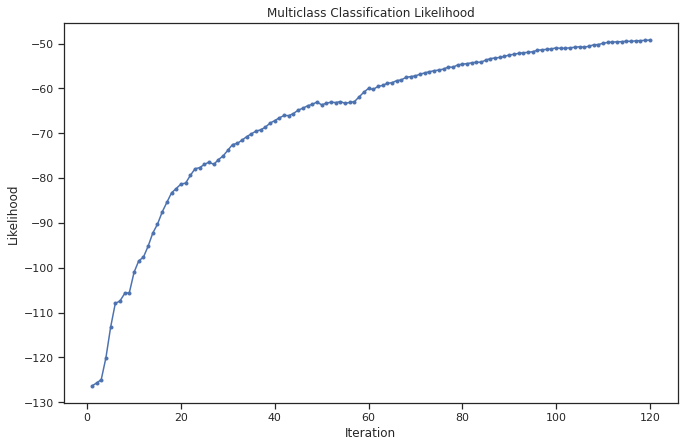

In [ ]:
#----------------------CALCULTE OPTIMAL WEIGHT WITH ONE SAMPLE A TIME FOR EACH STEP
#INITIATE THE WEIGHT MATRIX
theta_m = np.zeros((train_y.shape[1],train_x.shape[1]))

#EMPTY ARRAY FOR LIKELIHOOD
lld_multiclass = np.zeros(train_x.shape[0])
#LOOP THROUGH ALL SAMPLES FROM TRAINING SET
for sample_num in range(train_x.shape[0]):
  theta_m = sgd_1sample(train_x[sample_num,:],train_y[sample_num,:],0.038,theta_m)
  
  lld_multiclass[sample_num]=-lld_cal_multiclass(theta_m)

#CREATE INTERATION ARRAY
iteration = np.arange(1,121,1)
#---------------PLOT THE LIKELIHOOD VS ITERATIONS
plt.figure(figsize=(11,7))

plt.plot(iteration,lld_multiclass,marker='.')
plt.title('Multiclass Classification Likelihood')
plt.ylabel('Likelihood')
plt.xlabel('Iteration')
#plt.legend(loc='best')
plt.show()

In [ ]:
#----------------------PERCENT CORRECTNESS FOR ONE SMAPLE TO CALCULATE ONE STEP
p_c=percent_corr_multiclass(theta_m, test_x, test_y)
print("The percentage correctness for multiclass regression: ","{:.0%}".format(p_c))


The percentage correctness for multiclass regression:  80%
